<h1>Group 1 - Data Collection<span class="tocSkip"></span>

# Introduction

One of the sources we need to scrap was the Weibo a chinese website. This notebook contains the code to retrieve the data, translate chinese to english and also the Robot to retrieve the data once a week.

V0 : simple scraping and tags finding

V1 : transform code into functions and getting dates of publication 

V2 : adding traduction

V3 : fixing bugs

V4: improving quality and fixing last bugs

# Environment

## Libraries

In [1]:
import urllib.request
from bs4 import BeautifulSoup
import json
import os
from urllib.request import Request, urlopen
import re
import numpy as np
import datetime as dt
from textblob import TextBlob
import time
import pandas as pd

## Functions

This part contains all the functions we developped during the project

In [47]:
def textToDate(text: str):
    """Documentation    
       Parameters:
            text : character string     
       out : 
            date of  the publication'    
    """

    if "今天" in text:
        return dt.date.today()
    numbers_list = re.search("([0-9]*\w)*", text).group(0)
    numbers_list = re.findall(r"([0-9]+)", numbers_list)
    if len(numbers_list) == 3:
        year = numbers_list[0]
        month = numbers_list[1]
        day = numbers_list[2]

    elif len(numbers_list) == 2:
        now = dt.date.today()
        year = now.year
        month = numbers_list[0]
        day = numbers_list[1]
    else:
        return dt.date.today()
    return dt.date(int(year), int(month), int(day))

In [48]:
def getTextBetweenTags(texts: str, separator: str):
    """ Retrieving code between two tags

    Paramters:
        texts = Part of soup
        separator = Separator of soup
    Outers:
        description = Text wanted
    """
    text_clean = []
    lisI = []
    lisS = []

    for i in range(0, len(texts)):
        if str(texts[i]) == "<":
            lisI.append(i)
        if texts[i] == '>':
            lisS.append(i)

        len_lis = len(lisI)
    for h in range(0, len_lis):
        if h < (len_lis-1):
            text_clean.append(texts[lisS[h]:lisI[h+1]])

    if separator != 'non':
        description = str(text_clean).replace('>', '').replace(
            ',', '').replace('\'', '').replace('，', '')
        description = description.split(separator)
    else:
        description = text_clean

    return description

In [49]:
def upgradeDf(publication_date, description: str, shares: str, comm: str, like: str, df=None):
    """Documentation

       creation of the json file named weibo.json

       Parameters:
            publication_date : Date of the publication
            description : publication description
            shares : number or shares
            comm : comment
            like : number of likes

    """


    name_col = ['Data_Source',
                'Airline_Name',
                'Airline_Type',
                'Region_Operation',
                'Aircraft_Type',
                'Cabin_Class',
                'Type_Of_Lounge',
                'Type_Of_Traveller',
                'Date_Visit',
                'Date_Flown',
                'Airport',
                'Route',
                'Category',
                'Category_Detail',
                'Cabin_Staff_Service',
                'Lounge_Staff_Service',
                'Bar_And_Beverages',
                'Food_And_Beverages',
                'Ground_Service',
                'Catering',
                'Cleanliness',
                'Lounge_Comfort',
                'Aisle_Space',
                'Wifi_And_Connectivity',
                'Inflight_Entertainment',
                'Viewing_Tv_Screen',
                'Power_Supply',
                'Seat',
                'Seat_type',
                'Seat_Comfort',
                'Seat_Legroom',
                'Seat_Storage',
                'Seat_Width',
                'Seat_Recline', 
                'Washrooms',
                'Value_For_Money',
                'Overall_Customer_Rating',
                'Overall_Service_Rating',
                'Overall_Airline_Rating', 
                'Recommended', 
                'Date_Review', 
                'Review',
                'Departure_city',
                'Arrival_city', 
                'Nb_bus_taken', 
                'Nb_train_taken',
                'Nb_car_taken', 
                'Nb_plane_taken', 
                'Duration',
                'Price_min',
                'Price_max', 
                'Title',
                'Author', 
                'Description',
                'Date_publication', 
                'View_Count',
                'Likes',
                'Dislikes', 
                'Nb_subscribers',
                'Nb_comments',
                'Nb_sharing',
                'Hashtags',
                'Awards',
                'Registration',
                'Location',
                'Contributions_Pers',
                'Nb_pertinent_comments_Pers',
                'Queuing_Times', 
                'Terminal_Seating', 
                'Terminal_Signs', 
                'Airport_Shopping',
                'Experience_At_Airport']

    detailVideos = {}

    for i in name_col:
        detailVideos[i] = None

    if len(shares.replace(' ', '')) == 0:
        shares = '0'
    detailVideos['Data_Source'] = "Weibo"
    detailVideos['Description'] = translate(description)
    detailVideos['Nb_sharing'] = int(shares)
    detailVideos['Likes'] = int(like)
    detailVideos['Date_publication'] = str(publication_date)
    detailVideos['Nb_comments'] = int(comm)

    if df is None:
        df = pd.DataFrame(columns=list(detailVideos.keys()))
        df.loc[0, :] = list(detailVideos.values())
    else:
        df.loc[df.shape[0]+1, :] = list(detailVideos.values())
    return df

In [50]:
def translate(text:str):
    """Documentation    
       Parameters:
            text : character string     
       out : 
            text : text translated in english     
    """
    try:
        new = str(TextBlob(text).translate(to='en'))
        return new
    except:
        return text


def replace_all(text:str, dic):
    """Documentation    
       Parameters:
            text : character string
            dic  : dictionnary structured as (textToReplace : newText)
       out : 
            text : original text with string replacement as defined in the dictionnary  
    """
    for i, j in dic.items():
        text = text.replace(i, j)
    return text

# Crawl

In [51]:
# Get the lists of equation
AirCompanies = ["American Airlines", "Air Canada", "Air France", "Air Algerie", "Air India", "Aerolineas Argentinas", "Royal Air Maroc", "Finnair", "Alitalia ", " Nouvelair", "Air China", "Cathay Pacific", "Delta Airlines", "Aer Lingus", "Emirates", "Ethiopian Airlines", "Icelandair", "Hawaiian Airlines", "Iberia", "Meridiana", "Japan Airlines", "KLM", "Air Malta", "Lan Airlines", "Luxair", "LIAT", "LOT Polish Airlines", "Air Madagascar", "Air Mauritius", "Austrian Airlines", "Qatar Airways", "South African Airways", "SAS Scandinavian Airlines", "Brussels Airlines",
                "Singapore Airlines", "Corsair", "Aeroflot", "Thai Airways", "Turkish Airlines", "TAP Portugal", "Air Transat", "Tunisair", "Air Caraibes", "United Airlines", "Air Austral", "Air Europa", "Easyjet", "Vietnam Airlines", "Virgin Atlantic", "Air Corsica", "Condor", "Flybe", "Aegean Airlines", "Air Tahiti Nui", "Aigle Azur", "HOP!", "Jet Airways", "Etihad Airways", "Etihad Airways", "Oman Air", "XL Airways", "Ryanair LTD", "Vueling ", "Norwegian", "Transavia France", "Germanwings", "TUI Fly Belgium", "Air Arabia", "WOW air", "Wizz Air", "Air Asia", "Volotea", "southwest airlines"]
BoeingModel = ["Boeing 717", "Boeing 727", "Boeing 737-200", "Boeing 737-300", "Boeing 737-400", "Boeing 737-500", "Boeing 737-600", "Boeing 737-700", "Boeing 737-700ER", "Boeing 737-800", "Boeing 737-900", "Boeing 737-900ER", "Boeing 737 MAX 7",
               "Boeing 737 MAX 8", "Boeing 737 MAX 9", "Boeing 737 MAX 10", "Boeing 747-200", "Boeing 747-400", "Boeing 757-200", "Boeing 757-300", "Boeing 767-200", "Boeing 767-300", "Boeing 767-300ER", "Boeing 767-400ER", "Boeing 777 Triple Seven", "Boeing 787 DreamLiner"]
AirbusModel = ["A300", "A300-600ST", "A318", "A319", "A320-100", "A320-200", "A320neo", "A321-100", "A321-200", "A330-200",
               "A330-300", "A330-200F", "A330-500", "A340-200", "A340-300", "A340-500", "A340-600", "A350-900", "A350-1000", "A380-800", "A220-300"]
motsCles = ["trip", "fly", "plane", "airplane", "flight"]

url_list = []
for companie in AirCompanies:
    for model in AirbusModel:
        url_list.append('https://s.weibo.com/weibo/'+companie+'%2520'+model)
    for model in BoeingModel:
        url_list.append('https://s.weibo.com/weibo/'+companie+'%2520'+model)


In [52]:
# nb days to filter:
nb_day = 7
# we will filter post that are older that this limitDate
limitDate=str((dt.date.today() - dt.timedelta(days=(nb_day))))
# in exemple : nb_day = 7 gives you only post that have been written this week
df = None

for url in url_listz:
    url = url.replace(' ', '%20')
    req = Request(url, headers={'User-Agent': 'Mozilla/5.0'})
    web_page = urlopen(req).read()
    soup = BeautifulSoup(web_page, 'html.parser')
    counter = 0

    #     description

    texte = str(soup.findAll('p', attrs={'node-type': 'feed_list_content'}))
    description = getTextBetweenTags(texte, '\\n')
    del description[0]

    # like / share, comment / description
    like_list = []
    share_list = []
    comment_list = []
    for span in soup.findAll('a', attrs={'title': "赞"}):
        text = span.text.strip()
        if len(text.replace(' ', '')) == 0:
            text = '0'
        like_list.append(text)
    for span in soup.findAll('a'):

        text = span.text.strip()

        # get number of comments
        if text.startswith('转发'):
            if len(text[3:]) == 0:
                comment_list.append('0')
            else:
                comment_list.append(text[3:])

        # get number of share
        if text.startswith('评论'):
            if len(text[3:]) == 0:
                share_list.append('0')
            else:
                share_list.append(text[3:])
    # add publication stat in json if publication is "new"
    for span1 in soup.findAll('p', attrs={'class': 'from'}):
        for span in span1.findAll('a', attrs={'target': '_blank'}):
            if str(textToDate(span.text.strip())) >= limitDate:
                df = upgradeDf(textToDate(span.text.strip(
                )), description[counter], share_list[counter], comment_list
                    [counter], like_list[counter], df=df)
            counter += 1
    print(url, ' complete')
df.to_json("dataWeibo.json",orient ="index",force_ascii =False)
print('Every url completed')

https://s.weibo.com/weibo/American%20Airlines%2520A300  complete
https://s.weibo.com/weibo/American%20Airlines%2520A300-600ST  complete
Every url completed


### Some statistics

In [15]:
import matplotlib.pyplot as plt

In [5]:
df=pd.read_json("C:/Users/berna/Documents/interpromo/ProjetInterpromo2020/ProjetInterpromo2020/Rendu_projet/data_Weibo_complet.json",orient="index")

In [6]:
df

,Aircraft_Type,Airline_Name,Airline_Type,Airport,Airport_Shopping,Aisle_Space,Arrival_city,Author,Awards,Bar_And_Beverages,...,Terminal_Seating,Terminal_Signs,Title,Type_Of_Lounge,Type_Of_Traveller,Value_For_Money,View_Count,Viewing_Tv_Screen,Washrooms,Wifi_And_Connectivity
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
996,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
997,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
df["len_publication"]=[len(val) for val in df["Description"]]

In [11]:
col_to_describe=["Nb_sharing","Likes","Nb_comments","len_publication"]

In [14]:
df[col_to_describe].describe()

,Nb_sharing,Likes,Nb_comments,len_publication
count,3918.000000,3918.000000,3918.000000,3918.000000
mean,3666.550026,30384.798367,14250.313936,180.419602
std,11746.373572,101538.994302,41703.858468,112.072176
min,0.000000,0.000000,0.000000,12.000000
25%,68.000000,2169.000000,20.000000,112.000000
50%,349.000000,7038.000000,212.000000,136.000000
75%,1178.750000,9785.000000,934.000000,220.000000
max,69454.000000,598502.000000,227321.000000,522.000000


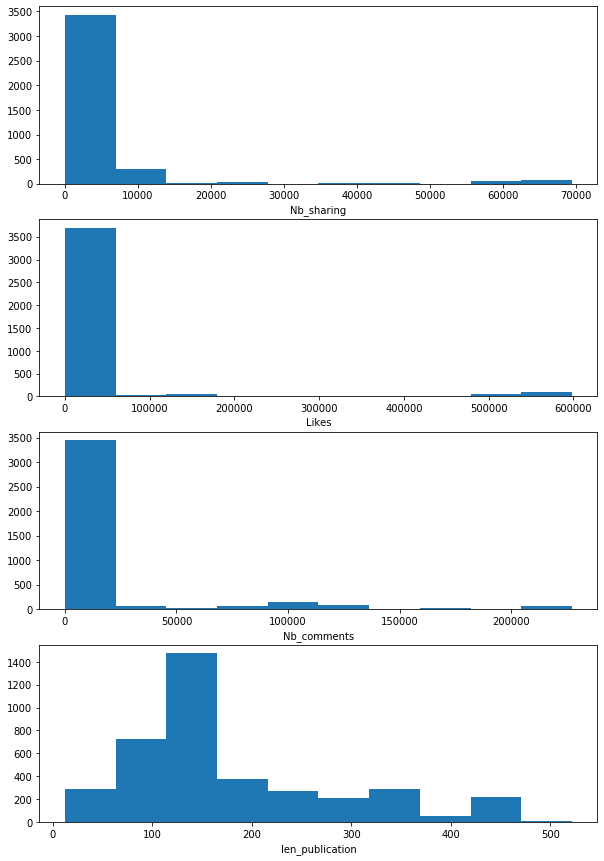

In [22]:
fig=plt.figure(figsize = (10, 15))
for i in range(4):
    axes=fig.add_subplot(4,1,i+1)
    plt.hist(df[col_to_describe[i]])
    axes.set_xlabel(col_to_describe[i])
plt.show()